In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
path_to_csv = os.path.join('..', 'experiments', 'Taylor_metrics_processed.csv')

In [3]:
df = pd.read_csv(path_to_csv, index_col=0)

In [4]:
df.head()

,run_id,MSEc,sigma_pred,sigma_true,seed,wds,placement,obs_rat,adjacency,tag,num,model,corr_coeff
0,anytown-fixrnd-0.05-binary-def-1-orig,329.145719,18.142374,18.142374,0,anytown,fixrnd,0.05,binary,def,1,orig,1.000000
1,anytown-fixrnd-0.05-binary-def-1-gcn,305.902143,17.431887,18.142374,0,anytown,fixrnd,0.05,binary,def,1,gcn,0.967262
2,anytown-fixrnd-0.05-binary-def-2-gcn,289.265015,16.723429,18.142374,0,anytown,fixrnd,0.05,binary,def,2,gcn,0.953403
3,anytown-fixrnd-0.05-binary-def-3-gcn,274.175302,16.311682,18.142374,0,anytown,fixrnd,0.05,binary,def,3,gcn,0.926479
4,anytown-fixrnd-0.05-binary-def-4-gcn,277.586525,16.270504,18.142374,0,anytown,fixrnd,0.05,binary,def,4,gcn,0.940380


# Preprocessing

In [5]:
df = df[~df['run_id'].str.contains('fixrnd')] # dropping old results
df['test_csv'] = df['run_id']
df['test_csv'] = df['test_csv'].apply(lambda fn: fn[:-4]+'_tst.csv')

# Loading test results

In [6]:
def read_test_result(fn):
    path_to_res = os.path.join('..', 'experiments', 'logs', fn)
    res_df = pd.read_csv(path_to_res, header=None, index_col=None, skiprows=1)
    res_dict = dict()
    for i in range(len(res_df)):
        res_dict[res_df.iloc[i][0]] = res_df.iloc[i][1]
    return res_dict

In [7]:
tempo_df = pd.DataFrame([read_test_result(fn) for fn in df['test_csv']], index=df['run_id'])
df.set_index('run_id', inplace=True)
df = df.join(tempo_df)

# Unique algo ids

In [8]:
ids = df.index.tolist()
algos = set()
for elem in ids:
    algos.add(elem.split('-')[1])

In [9]:
print(algos)

{'hdvar', 'xrandom', 'random', 'hydrodist', 'master', 'dist', 'hds'}


* master: entry nodes of tanks and reservoirs.
* random: nodes selected according to the uniform random distribution. Budget is the sum of the num. of master nodes and the original budget.
* xrandom: master + nodes selected according to the uniform random distribution.
* dist: shortest path weighted with pipe length.
* hydrodist: shortest path weighted with hydraulic distance.
* hdvar: shortest path weighted with nodal head variation.
* hds: shortest path weighted with nodal sensitivity.

In [10]:
df['plaseed'] = df['placement'] + '-' + df['seed'].astype(str)

In [11]:
df.head()

,MSEc,sigma_pred,sigma_true,seed,wds,placement,obs_rat,adjacency,tag,num,model,corr_coeff,test_csv,tst_loss,tst_rel_err,tst_rel_err_o,tst_rel_err_h,plaseed
run_id,,,,,,,,,,,,,,,,,,
anytown-master-1-binary-ms-1-gcn,313.845493,17.844183,18.142374,0,anytown,master,1.0,binary,ms,1,gcn,0.969449,anytown-master-1-binary-ms-1_tst.csv,0.001033,0.047284,0.018305,0.051860,master-0
ctown-master-5-binary-ms-1-gcn,1211.081307,34.768258,34.856233,0,ctown,master,5.0,binary,ms,1,gcn,0.999332,ctown-master-5-binary-ms-1_tst.csv,0.000043,0.008495,0.008044,0.008519,master-0
richmond-master-10-binary-ms-1-gcn,1148.633068,33.886460,33.914756,0,richmond,master,10.0,binary,ms,1,gcn,0.999462,richmond-master-10-binary-ms-1_tst.csv,0.000020,0.003933,0.004958,0.003919,master-0
anytown-dist-1-binary-ms-1-gcn,327.838056,18.174790,18.142374,0,anytown,dist,1.0,binary,ms,1,gcn,0.994251,anytown-dist-1-binary-ms-1_tst.csv,0.000197,0.020378,0.018502,0.020795,dist-0
ctown-dist-5-binary-ms-1-gcn,1213.378997,34.831008,34.856233,0,ctown,dist,5.0,binary,ms,1,gcn,0.999424,ctown-dist-5-binary-ms-1_tst.csv,0.000037,0.007849,0.004591,0.008064,dist-0


# Barplot
### Anytown

<AxesSubplot:xlabel='placement', ylabel='tst_rel_err_h'>

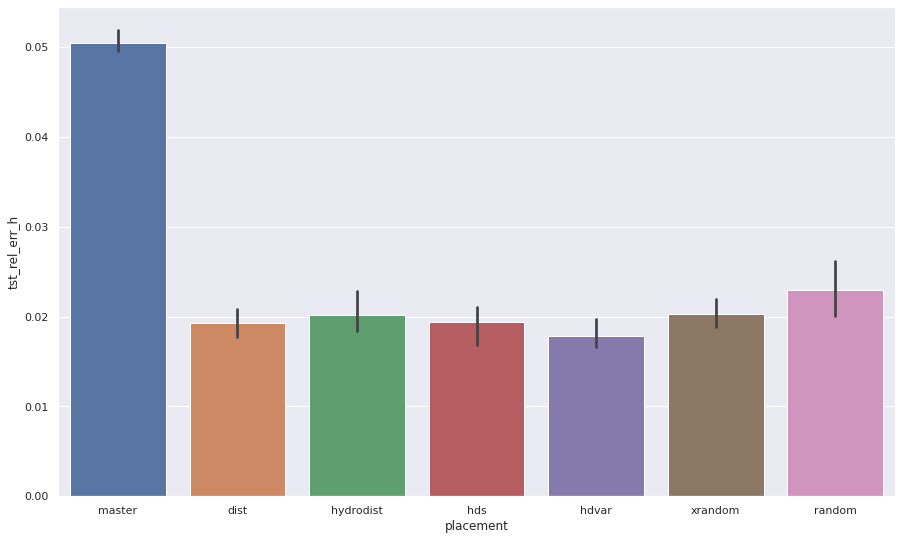

In [12]:
subdf = df[(df['wds'] == 'anytown')]# & (df['placement'] != 'random')]
sns.set(rc={'figure.figsize':(15,9)})
sns.barplot(data=subdf, x='placement', y='tst_rel_err_h')

### C-Town

<AxesSubplot:xlabel='placement', ylabel='tst_rel_err_h'>

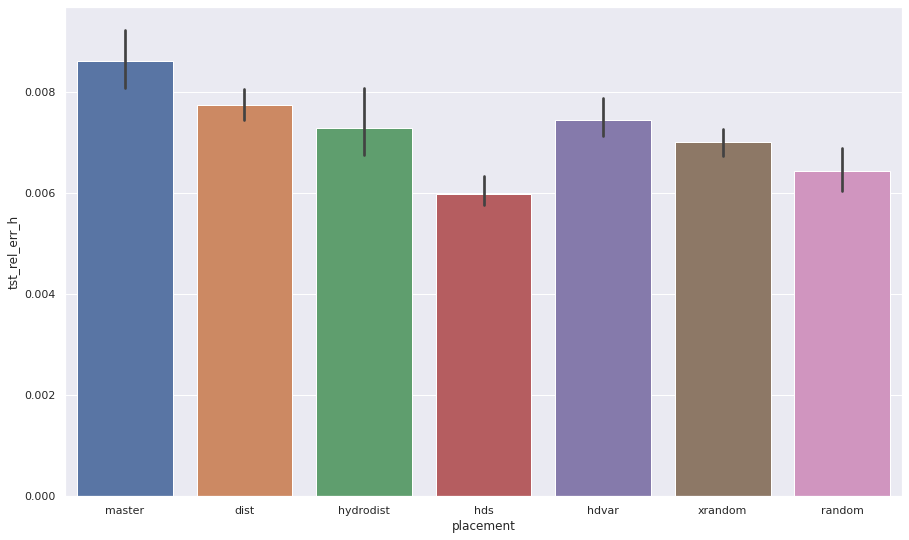

In [13]:
subdf = df[(df['wds'] == 'ctown')]# & (df['placement'] != 'random')]
sns.set(rc={'figure.figsize':(15,9)})
sns.barplot(data=subdf, x='placement', y='tst_rel_err_h')

### Richmond

<AxesSubplot:xlabel='placement', ylabel='tst_rel_err_h'>

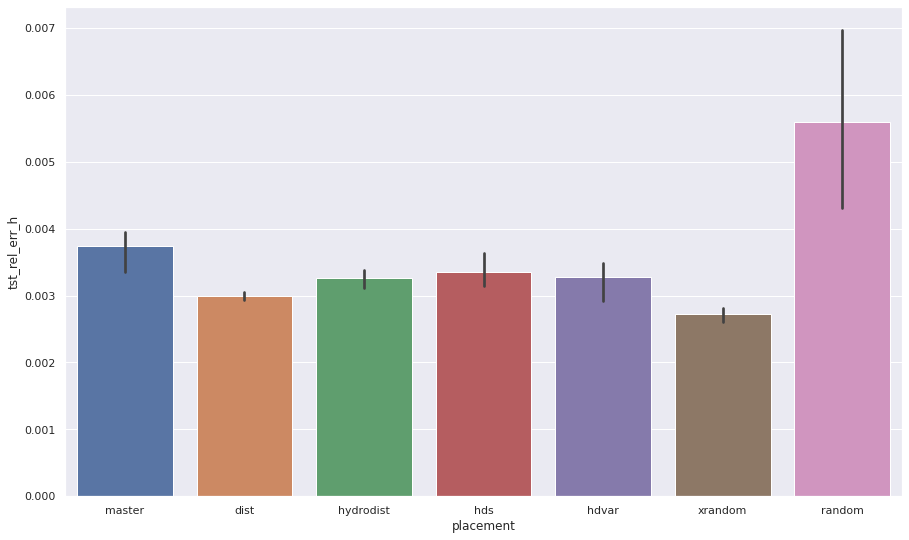

In [14]:
subdf = df[(df['wds'] == 'richmond')]# & (df['placement'] != 'random')]
sns.set(rc={'figure.figsize':(15,9)})
sns.barplot(data=subdf, x='placement', y='tst_rel_err_h')